In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Lecture 32

In [2]:
# Let's load in some functions we created last class

# Convert data to standard units
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x)  


# we can create a function to calculate the correlation coefficient
def correlation(t, label_x, label_y):
    x_in_standard_units = standard_units(t.column(label_x))
    y_in_standard_units = standard_units(t.column(label_y))
    return np.mean(x_in_standard_units * y_in_standard_units)


# function to calculate the slope 
def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd


# function to calculate the intercept
def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

## Regression Line 

In [3]:
# Helper function: Draw a line for a given slope, intercept, and possibly input location x
def draw_line(slope=0, intercept=0, x=None, color='r'):
    if x is None:
        x1, x2, y1, y2 = plots.gca().axis()
    x = make_array(x1, x2)
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
    
# Helper function: Produces a plot we will use for a dataset in this demo to visualize errors
def show_demographics_errors(slope, intercept, add_RMSE = False):
    
    # plot the demographics data and a few residuals on the plot
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)
    
    # get and print the RMSE
    if add_RMSE:
        x = demographics.column('College%')
        y = demographics.column('Median Income')
        y_predicted = slope*x + intercept
        rmse = np.sqrt(np.mean( (y - y_predicted)**2))  
        plots.title("RMSE: " + str(round(rmse, 2)))

In [4]:
# load demographic data 
demographics = Table.read_table('district_demographics2016.csv')
demographics.show(5)

State,District,Median Income,Percent voting for Clinton,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,34.1,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,33,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,32.3,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17.4,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,31.3,30.3


In [5]:
# select only the 'College%', 'Median Income' columns
demographics = demographics.select('College%', 'Median Income')
demographics.show(5)

College%,Median Income
24,47083
21.8,42035
22.8,46544
17,41110
30.3,51690


In [6]:
# Calculate the correlation
correlation(demographics, 'College%', 'Median Income')

0.8203507154277606

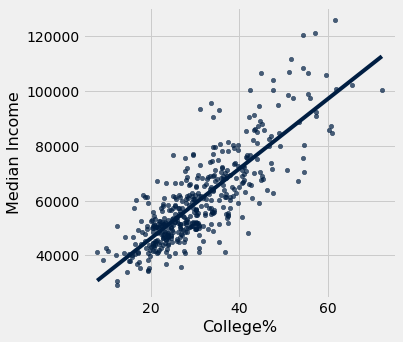

In [7]:
# visualize the data
demographics.scatter('College%', 'Median Income', fit_line = True)

In [8]:
# Calculate the slope and intercept
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
(regression_slope, regression_intercept)

(1273.6295735409858, 20712.135764074526)

In [9]:
# create a function that estimates all the predictions (fitted values)
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [10]:
# Predicted median incomes (y-hat values)
predicted = fitted_values(demographics, 'College%', 'Median Income')

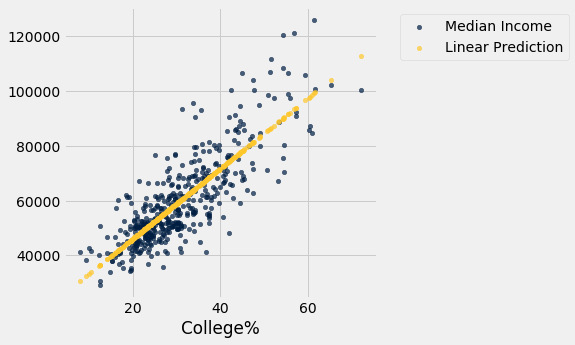

In [11]:
# Plot the linear predictions
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

## Residuals

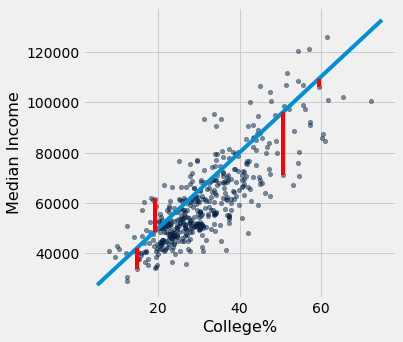

In [12]:
# Try any slope, any intercept
show_demographics_errors(1500, 20000)

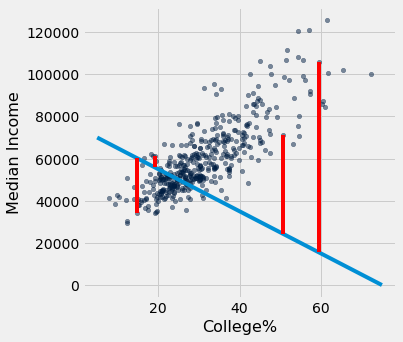

In [13]:
# Try any slope, any intercept
show_demographics_errors(-1000, 75000)

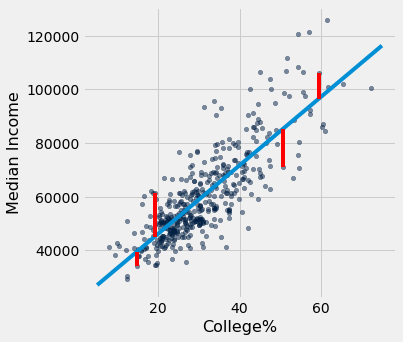

In [14]:
# Visualize errors for estimated line
show_demographics_errors(regression_slope, regression_intercept)

In [15]:
# Get all the residuals between the actual observations and the predicted values for the demographics data
actual = demographics.column('Median Income')
residuals = actual - predicted
demographics.with_column('Residuals', residuals)

College%,Median Income,Linear Prediction,Residuals
24,47083,51279.2,-4196.25
21.8,42035,48477.3,-6442.26
22.8,46544,49750.9,-3206.89
17,41110,42363.8,-1253.84
30.3,51690,59303.1,-7613.11
36.7,61413,67454.3,-6041.34
19.4,34664,45420.5,-10756.5
29.6,76440,58411.6,18028.4
24.5,50537,51916.1,-1379.06
34,49072,64015.5,-14943.5


## Root Mean Square Error

In [16]:
# Calculate the root mean squared error (RMSE) for the actual residuals
RMSE = np.mean(residuals ** 2) ** 0.5
RMSE

9398.566215673922

In [17]:
# function to calculate the RMSE for any splot and intercept for the demographic data
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

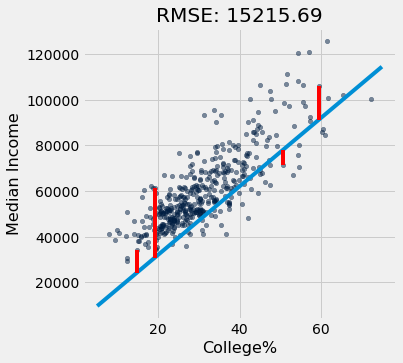

In [18]:
# show the demographic plot and the RMSE for an arbitrary slope and intercept

example_slope = 1500          #  -1000     500
example_intercept = 2000      #  75000     20000

demographics_rmse(example_slope, example_intercept)
show_demographics_errors(example_slope, example_intercept, True)

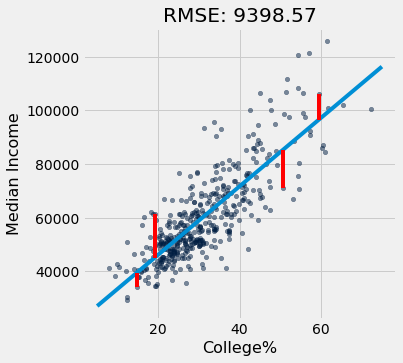

In [19]:
# The demographic plot and the RMSE for the slope and intercept (based on correlation formula) 
demographics_rmse(regression_slope, regression_intercept)
show_demographics_errors(regression_slope, regression_intercept, True)

## Numerical Optimization

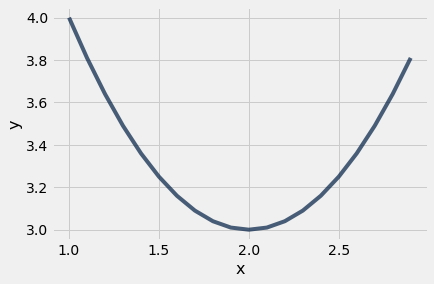

In [20]:
# An arbitrary function 
def f(x):
    return ((x-2)**2) + 3

# plot the function
x = np.arange(1, 3, 0.1)
y = f(x)
Table().with_columns('x', x, 'y', y).plot('x')

In [21]:
# find the minimum value of the function 
minimize(f)

1.9999999946252267

### Minimizing RMSE ###

In [22]:
# RMSE for arbitrary slope and intercept
demographics_rmse(1500, 20000)

11559.086490075999

In [23]:
# RMSE for another arbitrary slope and intercept
demographics_rmse(-1000, 75000)

30247.883767944502

In [24]:
# Minimize the demographic RMSE
minimize(demographics_rmse)

array([ 1270.70168805, 20802.57933807])

In [25]:
# Our regression slope and intercept estimates from earlier (based on correlation formula)
make_array(regression_slope, regression_intercept)

array([ 1273.62957354, 20712.13576407])

In [26]:
# The minimum RMSE value
demographics_rmse(regression_slope, regression_intercept)

9398.566215673922

## Regression diagnostic plots

In [27]:
### Galton data

In [28]:
galton = Table.read_table('galton.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
    )

In [29]:
def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

In [30]:
# add the fitted values and residuals to the height data
heights = heights.with_columns(
    'Fitted Value', fitted_values(heights, 'MidParent', 'Child'),
    'Residual', residuals(heights, 'MidParent', 'Child')
)
heights

MidParent,Child,Fitted Value,Residual
75.43,73.2,70.7166,2.48338
75.43,69.2,70.7166,-1.51662
75.43,69,70.7166,-1.71662
75.43,69,70.7166,-1.71662
73.66,73.5,69.5873,3.91271
73.66,72.5,69.5873,2.91271
73.66,65.5,69.5873,-4.08729
73.66,65.5,69.5873,-4.08729
72.06,71,68.5664,2.43358
72.06,68,68.5664,-0.566416


In [31]:
def plot_residuals(t, x, y):
    tbl = t.with_columns(
        'Predicted', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    tbl.select(x, y, 'Predicted').scatter(0)
    tbl.scatter(x, 'Residual')

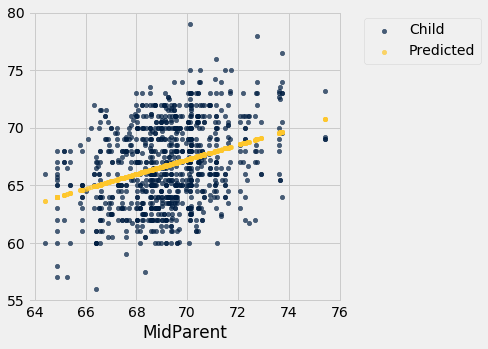

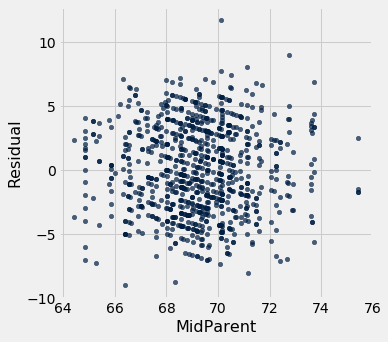

In [32]:
plot_residuals(heights, 'MidParent', 'Child')

### US women heights and average weights

In [33]:
# Height and average weight of US women
us_women = Table.read_table('us_women.csv')
us_women.show(5)

height,ave weight
58,115
59,117
60,120
61,123
62,126


In [34]:
correlation(us_women, 'height', 'ave weight')

1.0666015369116602

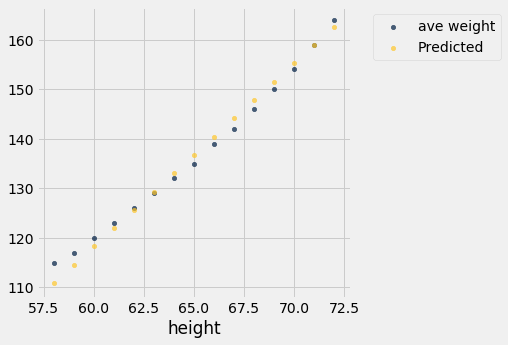

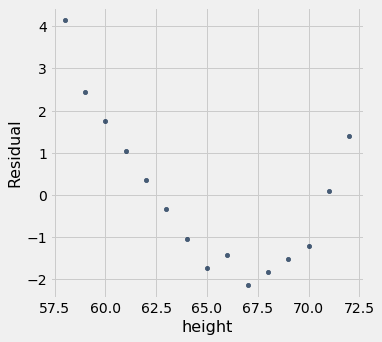

In [35]:
plot_residuals(us_women, 'height', 'ave weight')

## Polynomial regression

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.

In [36]:
def us_women_quadratic_rmse(a, b, c):
    x = us_women.column('height')
    y = us_women.column('ave weight')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [37]:
# get the quadratic fit coefficients
best_quad = minimize(us_women_quadratic_rmse)
best_quad

array([ 0.02482065,  0.23208032, 16.31511764])

Can you fill in the coefficients in the prediction equation? 

$$
f(x) ~=~ ax^2 + bx + c
$$

In [38]:
# What is the predicted average weight for someone who is 65 inches?
best_quad.item(0) * 65**2   +   best_quad.item(1) * 65   +    best_quad.item(2)



136.26759257362284

In [39]:
# create the fitted values for quadratic
heights = us_women.column('height')
fitted_values = best_quad.item(0)*(heights**2) + best_quad.item(1)*heights + best_quad.item(2)
fitted_values

array([113.27244908, 116.40854567, 119.59428356, 122.82966275,
       126.11468325, 129.44934506, 132.83364816, 136.26759257,
       139.75117829, 143.28440531, 146.86727363, 150.49978325,
       154.18193418, 157.91372641, 161.69515995])

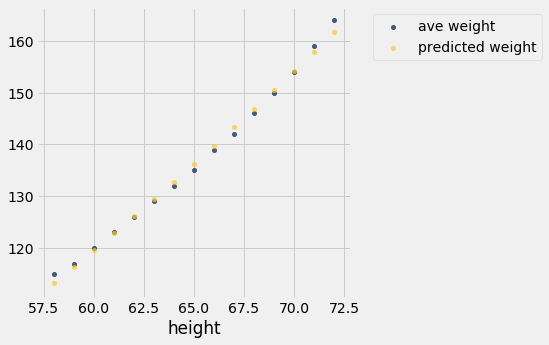

In [40]:
# plot the fitted values for the quadratic predictions
us_women.with_columns("predicted weight", fitted_values).scatter("height")

In [41]:
# calculate the residuals
residuals = us_women.column('ave weight') - fitted_values
residuals

array([ 1.72755092,  0.59145433,  0.40571644,  0.17033725, -0.11468325,
       -0.44934506, -0.83364816, -1.26759257, -0.75117829, -1.28440531,
       -0.86727363, -0.49978325, -0.18193418,  1.08627359,  2.30484005])

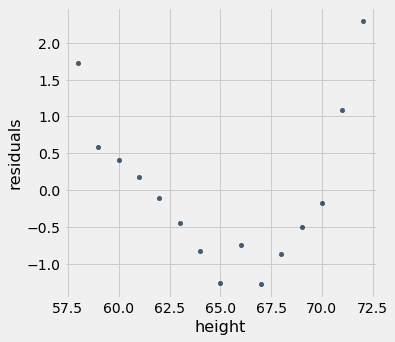

In [42]:
# plot the residuals
Table().with_columns("height", us_women.column('height'),
                     "residuals", residuals
).scatter("height")

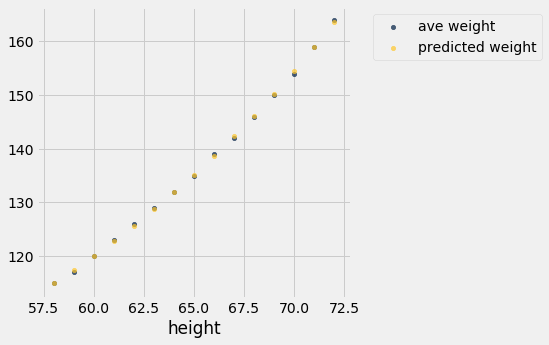

In [43]:
# Are higher order terms needed???
# Try a degree 5 polynomial at home!

def us_women_5_rmse(a, b, c, d, e, f):
    x = us_women.column('height')
    y = us_women.column('ave weight')
    estimate = a*(x**5) + b*(x)**4  + c*(x)**3 + d*(x)**2  + e*x + f
    return np.mean((y - estimate) ** 2) ** 0.5

best_order_5 = minimize(us_women_5_rmse)

fitted_values5 = best_order_5.item(0)*(heights**5) + best_order_5.item(1)*(heights**4) + best_order_5.item(2)*(heights**3) +  best_order_5.item(3)*(heights**2) + + best_order_5.item(4) * heights + best_order_5.item(5)

us_women.with_columns("predicted weight", fitted_values5).scatter("height")



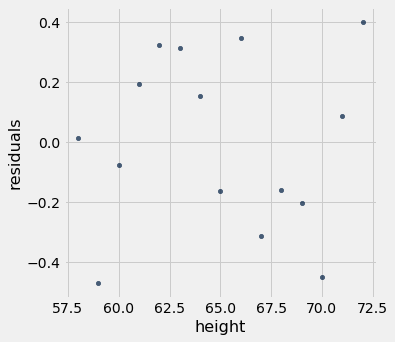

In [44]:
residuals = us_women.column('ave weight') - fitted_values5
residuals

Table().with_columns("height", us_women.column('height'),
                     "residuals", residuals
).scatter("height")